# RF model and Result

### Import python libraries

We use the sklearn library to call machine learning models, and use matplotlib and seaborn to draw diagrams.

In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load dataset x, y

In [26]:
data_x = np.load('data_x.npy')
data_y = np.load('data_y.npy')

In [27]:
data_x.shape

(2198, 10)

In [28]:
data_y.shape

(2198, 1)

### Plot the distribution of the samples

The diagonal graph is a distribution histogram of each feature, and the off-diagonal graph is a distribution of two features.We chose a total of 10 descriptors. Because there are many descriptors, we only draw the first three descriptors in the figure below.

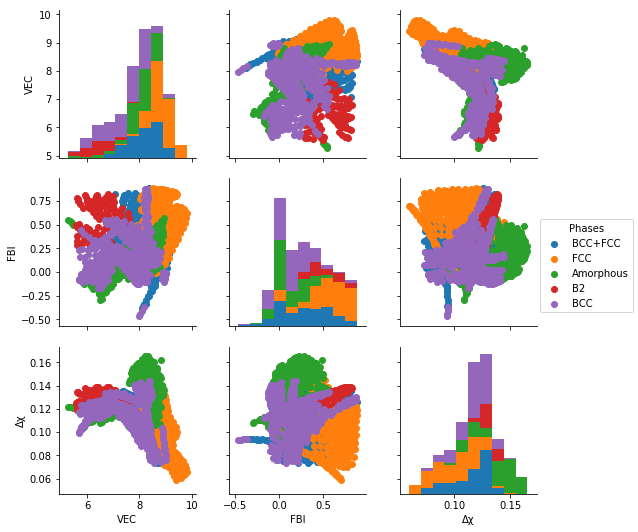

In [29]:
x = data_x ; y = data_y
col = ['VEC','FBI','Δχ',r'K$^{\rmV}$','W','δ','N',
    r'ΔH$_{\rmmix}$',r'T$^{\rmM}$',r'ΔS$_{\rmmix}^{\rmconf}$','Phases']
xy = np.hstack((x,y))
df = pd.DataFrame(xy,columns=col)

d = {1.0:"BCC", 2.0:"FCC", 3.0:"BCC+FCC",4.0:"B2",5.0:"Amorphous"}
df['Phases'] = df['Phases'].map(d)

graph = sns.PairGrid(df.iloc[:,[0,1,2,10]], hue="Phases")
graph.map_diag(plt.hist)
graph.map_offdiag(plt.scatter)
graph.add_legend()
plt.show()

### Divide the data set

We divide the data set into 80% training set and 20% test set.The following test is a single experiment (random_state in this experiment can be equal to any number). But in order to rule out chance, we need multiple experiments (random_state=None) and take the average.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(data_x,data_y.ravel(),test_size=0.2,
                                                    shuffle=True,random_state=7)

### 10-fold cross-validation grid search for hyperparameters

In [33]:
rf = RandomForestClassifier()
params = {'n_estimators': [50,100,150],
          'max_depth':[20,30,40]}

clf = GridSearchCV(rf,param_grid=params,cv=10)
clf.fit(X_train,y_train)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 100, 150], 'max_depth': [20, 30, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### Print out the training process

In [34]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

print("best CV_score: %0.3f   best parameter: %r" % (clf.best_score_, clf.best_params_))

0.933 (+/-0.043) for {'max_depth': 20, 'n_estimators': 50}
0.938 (+/-0.043) for {'max_depth': 20, 'n_estimators': 100}
0.933 (+/-0.041) for {'max_depth': 20, 'n_estimators': 150}
0.935 (+/-0.047) for {'max_depth': 30, 'n_estimators': 50}
0.934 (+/-0.032) for {'max_depth': 30, 'n_estimators': 100}
0.937 (+/-0.035) for {'max_depth': 30, 'n_estimators': 150}
0.932 (+/-0.042) for {'max_depth': 40, 'n_estimators': 50}
0.936 (+/-0.045) for {'max_depth': 40, 'n_estimators': 100}
0.936 (+/-0.036) for {'max_depth': 40, 'n_estimators': 150}
best CV_score: 0.938   best parameter: {'max_depth': 20, 'n_estimators': 100}


Print out the score of the test set

In [35]:
score = clf.score(X_test,y_test.ravel())
print(score)

0.9477272727272728


### Precision and Recall

In [36]:
from sklearn.metrics import classification_report

y_predict = clf.best_estimator_.predict(X_test)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

         1.0       0.93      0.95      0.94       102
         2.0       0.95      0.98      0.96       121
         3.0       0.93      0.90      0.92        90
         4.0       0.94      0.94      0.94        31
         5.0       0.98      0.96      0.97        96

   micro avg       0.95      0.95      0.95       440
   macro avg       0.95      0.94      0.94       440
weighted avg       0.95      0.95      0.95       440



### ROC curve

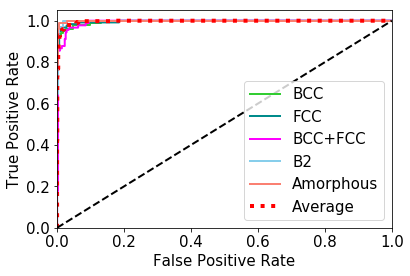

In [37]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle
yy = label_binarize(y, classes=[1,2,3,4,5])
y_test_2 = label_binarize(y_test, classes=[1,2,3,4,5])
n_classes = yy.shape[1]
labels = ['BCC', 'FCC', 'BCC+FCC', 'B2', 'Amorphous']

classifier = OneVsRestClassifier(clf.best_estimator_)

if hasattr(classifier, "decision_function"):
    y_score = classifier.fit(X_train, y_train).decision_function(X_test)
else:
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_2[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["average"], tpr["average"], _ = roc_curve(y_test_2.ravel(), y_score.ravel())
roc_auc["average"] = auc(fpr["average"], tpr["average"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

lw = 2
colors = cycle(["limegreen","darkcyan","magenta","skyblue","salmon"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
            label='{0}'
            ''.format(labels[i]))
plt.plot(fpr["average"], tpr["average"],
        label='Average',
        color='red', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel('False Positive Rate',size=15)
plt.ylabel('True Positive Rate',size=15)

plt.legend(loc="lower right",prop = {'size':15})

plt.show()